# EDA with PyPlot
A large number of diverse features makes it difficult to understand what really matters at the end. A solution to this problem is EDA, and Plotly library makes it easier,interactive and gives it a catchy look. I have explored the PyPlot API by visualizing a number of numerical, ordinal, and categorical features. Please hit an upvote if you like it!<br>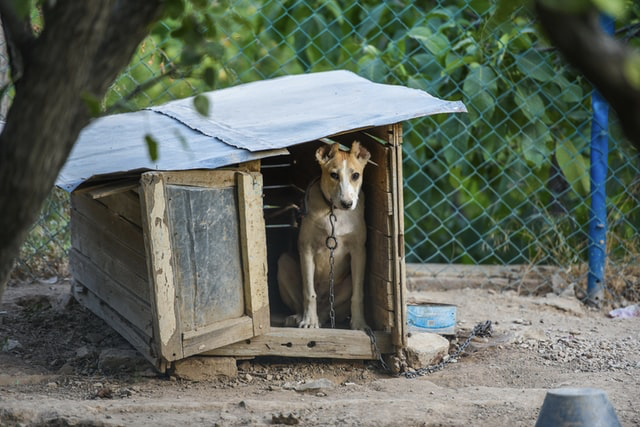


EDA gives an idea about how to encode a catagorical feature, whether to encode by label or get dummies. By a look at a graph we'll be able to decide how to scale features, how to impute the missing values, and how do they affect our target to be predicted. Let's get into it!

# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import sklearn
import statistics 
import math  

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from plotly.offline import init_notebook_mode, iplot, plot

# A look at the data

In [2]:
data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
target = data['SalePrice']
data.shape

(1460, 81)

Constituent data types 

In [3]:
data.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

For better understanding of the data, let's seperate the numerical and the catagorical features. 

In [4]:
numerical_cols = []
object_cols = []

[numerical_cols.append(i) for i in data.columns if data[i].dtype == 'int64' or data[i].dtype == 'float64']
[object_cols.append(i) for i in data.columns if data[i].dtype == 'O'];


# Numerical Data

Filling NUll values of the numerical features.

In [5]:
for i in numerical_cols:
    print("{} : {}%" .format (i , 100*(data[i].isnull().sum()/data.shape[0])))
    data[i].fillna(value =0,inplace=True)

Id : 0.0%
MSSubClass : 0.0%
LotFrontage : 17.73972602739726%
LotArea : 0.0%
OverallQual : 0.0%
OverallCond : 0.0%
YearBuilt : 0.0%
YearRemodAdd : 0.0%
MasVnrArea : 0.547945205479452%
BsmtFinSF1 : 0.0%
BsmtFinSF2 : 0.0%
BsmtUnfSF : 0.0%
TotalBsmtSF : 0.0%
1stFlrSF : 0.0%
2ndFlrSF : 0.0%
LowQualFinSF : 0.0%
GrLivArea : 0.0%
BsmtFullBath : 0.0%
BsmtHalfBath : 0.0%
FullBath : 0.0%
HalfBath : 0.0%
BedroomAbvGr : 0.0%
KitchenAbvGr : 0.0%
TotRmsAbvGrd : 0.0%
Fireplaces : 0.0%
GarageYrBlt : 5.5479452054794525%
GarageCars : 0.0%
GarageArea : 0.0%
WoodDeckSF : 0.0%
OpenPorchSF : 0.0%
EnclosedPorch : 0.0%
3SsnPorch : 0.0%
ScreenPorch : 0.0%
PoolArea : 0.0%
MiscVal : 0.0%
MoSold : 0.0%
YrSold : 0.0%
SalePrice : 0.0%


# Bar Plot - feature selection (numerical)
Let's checkout the most important numerical features in the dataset

In [6]:
corr_df = data[numerical_cols].corr(method='pearson')
corr_df = corr_df['SalePrice'].sort_values()
fig = px.bar(corr_df[11:-1],color=corr_df[11:-1].values)
fig.update_layout(title = 'Correlation scores of top numerical features w.r.t SalePrice',
                  xaxis= dict(title= 'Features',showgrid=False,gridcolor='lightgrey'),
                  yaxis= dict(title= 'SalePrice',showgrid=False),
                  plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [7]:
#taking the most important features into consideration and excluding the rest.
numerical_cols = []
[numerical_cols.append(i) for i in corr_df[11:-1].index];

# Catagorical features
Now, since the numerical features selection has been done, let's analyze the correlation of the catagorical features with respect to the Target variable. 

In [8]:
[data.groupby(i).mean()['SalePrice'] for i in object_cols]

[MSZoning
 C (all)     74528.000000
 FV         214014.061538
 RH         131558.375000
 RL         191004.994787
 RM         126316.830275
 Name: SalePrice, dtype: float64,
 Street
 Grvl    130190.500000
 Pave    181130.538514
 Name: SalePrice, dtype: float64,
 Alley
 Grvl    122219.080000
 Pave    168000.585366
 Name: SalePrice, dtype: float64,
 LotShape
 IR1    206101.665289
 IR2    239833.365854
 IR3    216036.500000
 Reg    164754.818378
 Name: SalePrice, dtype: float64,
 LandContour
 Bnk    143104.079365
 HLS    231533.940000
 Low    203661.111111
 Lvl    180183.746758
 Name: SalePrice, dtype: float64,
 Utilities
 AllPub    180950.95682
 NoSeWa    137500.00000
 Name: SalePrice, dtype: float64,
 LotConfig
 Corner     181623.425856
 CulDSac    223854.617021
 FR2        177934.574468
 FR3        208475.000000
 Inside     176938.047529
 Name: SalePrice, dtype: float64,
 LandSlope
 Gtl    179956.799566
 Mod    196734.138462
 Sev    204379.230769
 Name: SalePrice, dtype: float64,
 Neig

Dropping columns with majority missing values, since they're are not reliable, or they might not always be available while predicting on test cases.

In [9]:
drop_cols =[ i for i in object_cols if 100*(data[i].isnull().sum()/data.shape[0])>40]
for i in drop_cols:
    x = 100*(data[i].isnull().sum()/data.shape[0])
    print("{} : {}%" .format (i ,x))
[object_cols.remove(i) for i in drop_cols];

Alley : 93.76712328767123%
FireplaceQu : 47.26027397260274%
PoolQC : 99.52054794520548%
Fence : 80.75342465753424%
MiscFeature : 96.30136986301369%


Filling the minor missing values with the mode.

In [10]:
for i in object_cols:
    data[i].fillna(value = data[i].mode()[0], inplace = True)

# Scatter plot- Look at the relation between general features of a house.
PLotting Above ground living area with respect to total basement area, colored according to the overall quality of the apartment. The sizes define the garage area. 

In [11]:
fig = px.scatter(data, x="TotalBsmtSF", y="GrLivArea", size="GarageArea", color="OverallQual",
           hover_name="HouseStyle",log_x = True)
fig.update_layout(title = "GrLivArea vs TotalBsmtSF scaled by quality and Type of House")
fig.show()


Biggest group living spaces correspond to biggest basements and as we can see, most of them are highly rated on quality. The smaller ones, even though they should be easier to maitain, have rather been rated less. Perhaps, people care more about large living area.

# Scatter matrix- Another way to look at the general features
Plotting the overall quality, above ground living area, basement area and garage area against each other, colored according to the building types. 

In [12]:
fig = px.scatter_matrix(data, dimensions=["OverallQual", "GrLivArea", "TotalBsmtSF", "GarageArea"], color="BldgType")
fig.show()

Blue wins! Or the single family building types populate majority of the data. We can see townhouse units a little here and there. Duplexes are a rare choice. Also we can conclude the fact that houses with garages are well appreciated, judging by the high overall quality rating.

# Easy and Custom scatter plots for visualizing multiple features at once:
I have visualized the Open porch area and Screen Porch with respect to the Saleprice. We can judge the spread of the data, the avarage and most prefered values of each features from such plots.

In [13]:
trace1 = go.Scatter(
                    x = data.OpenPorchSF,
                    y = data.SalePrice,
                    mode = "markers",
                    name = "Open Porch SF",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text= data.OpenPorchSF)

trace2 = go.Scatter(
                    x = data.ScreenPorch,
                    y = data.SalePrice,
                    mode = "markers",
                    name = "Screen Porch SF",
                    marker = dict(color = 'peachpuff'),
                    text= data.ScreenPorch)
df = [trace1, trace2]
layout = dict(title = 'SalePrices per Porch area square feet',
              xaxis= dict(title= 'Porch Type(open/screen)',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'SalePrice',ticklen= 5,zeroline= False),
              plot_bgcolor='rgba(0,0,0,0.7)'
             )
fig = dict(data = df, layout =layout)
iplot(fig)

# Scatter plot - with trendlines and error bars
Trendlines give a sense of direction to a scatterd mess, also extrapolated the existing data.In Pyplot the hover data also lists the R2 score of the features. Error bars are the best to analyse distribution of data about their mean,how deviated they are. I have visualised the characterestics of the Lot dimensions with their shpapes.

In [14]:
fig = px.scatter(data, x="LotFrontage", y="LotArea", color="LotShape", marginal_y="violin",
           marginal_x="box", trendline="ols", template="simple_white")
fig.show()

# Grouped bar plots: Comparison of similar features and their relationship with the saleprice.

Exterior type 1 and 2 have similar catagories, though the numbers are different. Let's compare them against saleprice.

In [15]:
df0 = data.groupby(['Exterior1st']).median()['SalePrice']
df0 = df0.sort_values()
df1 = data.groupby(['Exterior2nd']).median()['SalePrice']

trace0 = go.Bar(
    x = df0.index,
    y = df0,
    name ="Exterior1st",
    marker = dict(color = 'palevioletred')
)
trace1 = go.Bar(x = df0.index,
    y = df1,
     name ="Exterior2nd",            
    marker = dict(color = 'papayawhip') )
dfr = [trace0,trace1]
layout = dict(title = 'Median of SalePrices per Exterior Categories',
              xaxis= dict(title= 'Exterior',ticklen= 6,showgrid=False),
              yaxis= dict(title= 'SalePrice',ticklen= 6,showgrid=False),
              plot_bgcolor='rgba(0,0,0,0.2)',
             )
fig = dict(data = dfr, layout =layout)

iplot(fig)

I have plotted medians rather than means to avoid getting manipulated by outliners of skewness in the data catagories. Type 1 has been plotted in ascending order for better comparison. Imitation Stucco have the highest mid prices for type 1, but pretty low in type 2. Brick Face is the highest priced for type 2. Probably these correspond to the front of the house and back of house respectively for type 1 and 2 judging by the difference in materials preferred. Box plots would give a better idea about the general spread of the data. Let's move on.

# Box Plot - EDA masters (Why? they list the mean,spread,outliners,skewness and catagories at once)
I love box plots, because of the amount of information they hold about the data plotted on them. 

I have plotted the exterior architecture type with respect to the SalePrice. It will show the extreme SalePrices with respect to exterior type, hence the outliners. We will also how exterior types differ in the way they are priced on avarage.

In [16]:
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Box(
                    x = data.Exterior1st,
                    y = data.SalePrice,
                    name = "Exterior1st",
                    marker = dict(color = 'palevioletred'),
                    text= data.Exterior1st),
             row=1, col=1
            )
fig.add_trace(go.Box(
                    x = data.Exterior2nd,
                    y = data.SalePrice,
                    name = "Exterior2nd",
                    marker = dict(color = 'paleturquoise'),
                    text= data.Exterior2nd),
             row=2, col=1
            )
fig.update_xaxes(title_text="Exterior1st", row=1, col=1)
fig.update_xaxes(title_text="Exterior2nd", row=2, col=1)
fig.update_yaxes(title_text="SalePrice", row=1, col=1)
fig.update_yaxes(title_text="SalePrice", row=2, col=1)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.update_layout(
              plot_bgcolor='rgba(0,0,0,1)',title_text="SalePrices per Exterior Finishing square feet")
iplot(fig)

Vinyl sliding is the highest priced exterior type for dwellings. Its range of prices is pretty spread too. Cement beds have a lower avarage but they have a skew in their price trend. CBlocks are rarely preffered.<br>
Locations and zones must manipulate the prices of the apartments, hence i have plotted them against each other. Roof Styles, House Styles, Building styles come next in our minds while setting the prices. Let's have a look.

In [17]:
fig = make_subplots(rows=3, cols=2)
fig.add_trace(go.Box(
    arg = dict(
    y = data["SalePrice"],
    x = data["HouseStyle"]),
    name = "House Style",
    text= "House Style"
),row=1,col=1)


fig.add_trace(go.Box(
    arg = dict(
    y = data["SalePrice"],
    x = data["Neighborhood"]),
    name = "Neighborhood",
    text= "House Style"
),row=1,col=2)

fig.add_trace(go.Box(
    arg = dict(
    y = data["SalePrice"],
    x = data["MSZoning"]),
    name = "MSZoning",
    text= "MSZoning"
),row=2,col=1)

fig.add_trace(go.Box(
    arg = dict(
    y = data["SalePrice"],
    x = data["BldgType"]),
    name = "BldgType",
    text= "Building Type"
),row=2,col=2)

fig.add_trace(go.Box(
    arg = dict(
    y = data["SalePrice"],
    x = data["RoofStyle"]),
    name = "RoofStyle",
    text= "Roof Style"
),row=3,col=1)
fig.add_trace(go.Box(
    arg = dict(
    y = data["SalePrice"],
    x = data["BsmtCond"]),
    name = "Basement Condition",
    text= "Basement condition"
),row=3,col=2)


fig.update_layout(title = 'SalePrices per Amenities',height=800, width=1000,
              plot_bgcolor='rgba(0,0,0,0)')
fig.show()


For the location of the apartments, Northridge Heights and Stone Brook are the costliest neighborhoods in the Ames city limits, while Northpark Villa and Blustem are the cheapest ones.Cheapest zones include commericial and Residential High Density zones, quite intuitive and the costliest are Residential low and medium density zones.<br>

2 storey house styles will be difficult to afford, thanks to their high prices, and single family building, most probably because of their demand they are costly.
Types of basments dont affect the saleprices much, judging by their almost similar avarages, tho houses with typical have a lot of outliners.
Hip roof styles have outliners and they are pretty much deviated from their mean. They can be costly, they can be not, nothing much can be said about it in this case.

# Pie Charts: Explore majority and minority in catagories
Normal Pie charts and sunburst plots say a lot about composition of that data. The hover data can contain all the nessacary information you'd like to include and know about. Plotly pie charts are easily customizable.

I have plotted a sunburst chart for visualizing the neighborhoods in each zones. And their overall quality and saleprices. Let's have a look:

In [18]:
fig = px.sunburst(data, path=['MSZoning','Neighborhood'], values='SalePrice',
                  color='OverallQual')
fig.update_layout()
fig.show()

Most neighborhoods are listed under low density residential zones, which are pretty high priced and have a good rating, as we saw earlier as well. Few zones such such as medium density residential and floating village residential. They are pretty cheap zones, as we can see from the sector sizes. 

# Custom Pie Charts: Plotting Catagories and numerical features against each other.
Basement area with respect to their quality and condition.

In [19]:
fig1 = px.pie(data, values='TotalBsmtSF', names='BsmtCond', title='Total basement area vs condition')
fig1.show()
fig2 = px.pie(data, values='TotalBsmtSF', names='BsmtQual', title='Total Basement area vs quality')
fig2.show()

# 3D scatter plots: Information overload.
I have plotted the garage attributes to the 3D scatter plot matrix. The garage finishing status, garage Condition, garage types against each other. The sizes are with respect to the relative garage area and colored with respect to the types.

In [20]:
fig = px.scatter_3d(data, x="GarageFinish", y="GarageCond", z="GarageType", color="GarageType", size="GarageArea",
                  symbol="GarageType")
fig.show()

# Data Preparation:
That was enough of visualizations, now lets scale and convert the data to prepare it for modelling.

# Scaling data: Standard Scaling, and dropping unnecessary columns. 

In [21]:
for i in numerical_cols:
    data[i] = (data[i]-np.mean(data[i]))/np.std(data[i])
final_cols = numerical_cols
final_cols.append('SalePrice')
[final_cols.append(i) for i in object_cols]
for i in data.columns:
    if i not in final_cols:
        data.drop(i,inplace=True,axis=1)

# Label Encoding and One hot encoding

In [22]:
label_encoding_cols  = {'LotShape': {'IR3':1, 'IR2':2, 'IR1':3,'Reg':4},
                        'LotConfig': {'Inside': 1, 'Corner':2, 'CulDSac':3,'FR2':4,'FR3':5},
                        'LandSlope': {'Sev': 1, 'Mod':2, 'Gtl':3},
                        "ExterQual": {"NA":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},
                        "ExterCond": {"NA":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},
                        "BsmtQual": {"NA":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},
                        "BsmtCond": {"NA":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},
                        "BsmtExposure": {"NA": 0, "No": 0, "Mn": 1, "Av": 2,"Gd":3},
                        "BsmtFinType1": {"NA": 0, "Unf": 1, "LwQ": 2, "Rec": 3,"BLQ": 4, "ALQ": 5, "GLQ":5 },
                        "BsmtFinType2": {"NA": 0, "Unf": 1, "LwQ": 2, "Rec": 3,"BLQ": 4, "ALQ": 5, "GLQ":5 },
                        "HeatingQC": {"NA":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},
                        "CentralAir": {'N':0,'Y':1},
                        "KitchenQual": {"NA":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},
                        "Functional": {"Sal":0,"Sev":1,"Maj1":2,"Maj2":2,"Mod":3,"Min1":4,'Min2':4,'Typ':5},
                        "GarageType": {"CarPort":0,"2Types":1,"Detchd":2,"Basment":3,"BuiltIn":4,"Attchd":5},
                        "GarageFinish": {"No Garage":0,"Unf":1,"RFn":2,"Fin":3},
                        "GarageQual": {"NA":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},
                        "GarageCond": {"NA":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},
                        'SaleCondition' : {'Partial':0,'Family':1,'Alloca':2,'AdjLand':3,'Abnorml':4,'Normal':5}}
data = data.replace(label_encoding_cols)

# Visualizing the nominal features before one hot encoding them

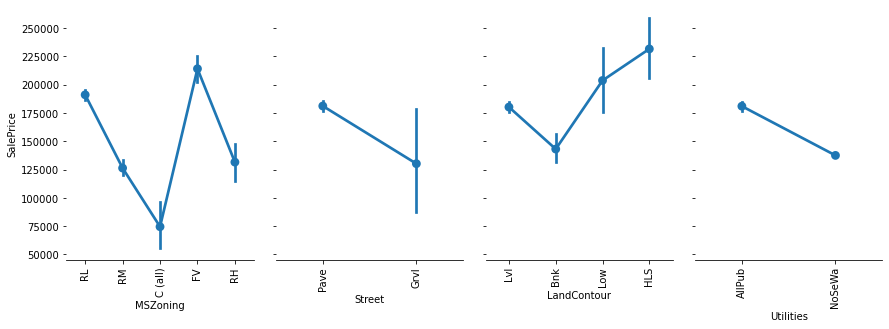

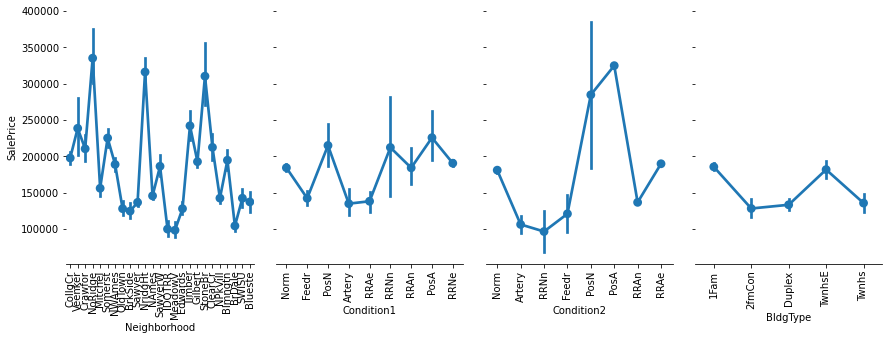

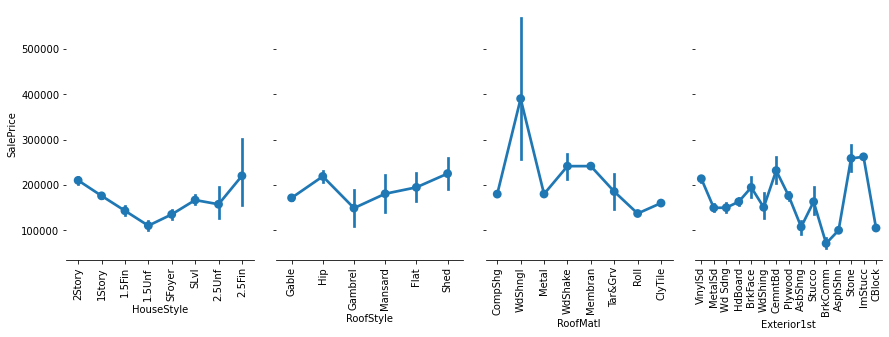

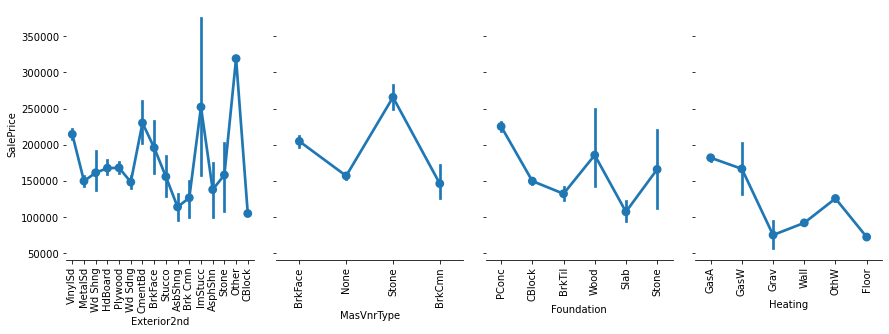

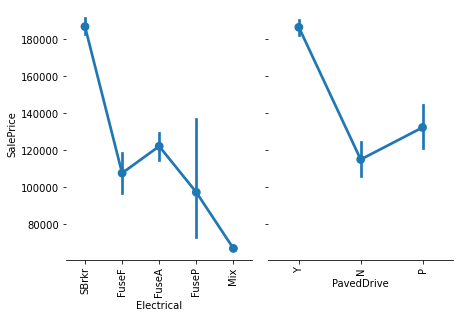

In [23]:
one_hot_cols = [i for i in object_cols if data[i].dtype == 'O']

j=0
for i in [4,8,12,16,-1]:
    g = sns.PairGrid(data, y_vars="SalePrice",
                 x_vars= one_hot_cols[j:i],height = 4, aspect = 0.75)
    g.map(sns.pointplot)
    for ax in g.axes.flat: 
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    sns.despine(fig=g.fig, left=True)
    j=i

In [24]:
for i in one_hot_cols:
    data[i] = data[i].astype('category')
data1 = pd.get_dummies(data, drop_first = True, columns = one_hot_cols)

# Standardizing the entire dataset

In [25]:
cols = data1.columns
scaler = StandardScaler()
data1 = scaler.fit_transform(data1)
data1 = pd.DataFrame(data1, columns = cols )

In [26]:
data1.head()

,LotFrontage,LotArea,LotShape,LotConfig,LandSlope,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,0.212877,-0.207142,0.701291,-0.538603,0.225716,0.651479,1.050994,0.878668,0.514104,1.052302,...,-0.144841,0.299253,-0.052414,-0.037037,-0.078757,-0.058621,-0.058621,-0.301962,-0.045376,0.390293
1,0.645747,-0.091886,0.701291,3.341462,0.225716,-0.071836,0.156734,-0.429577,-0.570750,-0.689604,...,-0.144841,0.299253,-0.052414,-0.037037,-0.078757,-0.058621,-0.058621,-0.301962,-0.045376,0.390293
2,0.299451,0.073480,-1.016637,-0.538603,0.225716,0.651479,0.984752,0.830215,0.325915,1.052302,...,-0.144841,0.299253,-0.052414,-0.037037,-0.078757,-0.058621,-0.058621,-0.301962,-0.045376,0.390293
3,0.068587,-0.096897,-1.016637,0.754752,0.225716,0.651479,-1.863632,-0.720298,-0.570750,-0.689604,...,-0.144841,0.299253,-0.052414,-0.037037,-0.078757,-0.058621,-0.058621,-0.301962,-0.045376,0.390293
4,0.761179,0.375148,-1.016637,3.341462,0.225716,1.374795,0.951632,0.733308,1.366489,1.052302,...,-0.144841,0.299253,-0.052414,-0.037037,-0.078757,-0.058621,-0.058621,-0.301962,-0.045376,0.390293


Now the data is ready for modelling.